<a href="https://colab.research.google.com/github/Shankar-Hadimani/1000_test/blob/master/notebooks/DL/Gender_Determination_by_Morphometry_of_Eyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the images

In [345]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
                                    dest_path='content/eye_gender_data.zip',
                                    unzip=True)

## Loading Libraries

In [346]:
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool
import os                                               # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

## Loading and preparing training data


In [347]:
labels = pd.read_csv("/content/content/eye_gender_data/Training_set.csv")   # loading the labels
file_paths = [[fname, '/content/content/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')

In [348]:
print('size of the train set: ', train_data.shape)
labels['label'].value_counts()

size of the train set:  (9220, 3)


male      5058
female    4162
Name: label, dtype: int64

In [349]:
data = []                                                                     # initialize an empty numpy array
image_size = 100                                                              # image size taken is 100 here. one can take other size too
X_Image = []
y_label = []
for i in range(len(train_data)):
  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (image_size, image_size))            # resizing the image array
  data.append([new_img_array, train_data['label'][i]])
  X_Image.append([new_img_array])
  y_label.append(train_data['label'][i])

In [350]:
X_Image[:1]

[[array([[188, 188, 189, ..., 176, 175, 175],
         [189, 189, 188, ..., 174, 173, 172],
         [190, 189, 188, ..., 168, 167, 167],
         ...,
         [133, 137, 144, ..., 168, 167, 166],
         [134, 138, 145, ..., 165, 164, 163],
         [135, 139, 146, ..., 163, 162, 162]], dtype=uint8)]]

In [351]:
y_label[:1]

['male']

In [352]:
#  Normlaize the input dataset
X_Image_arr = np.array(X_Image) / 255.0
y_label_arr = np.array(y_label)

In [353]:
# Summarize Loaded Dataset
print('Train data: X=%s, y=%s' % (X_Image_arr.shape, y_label_arr.shape))

Train data: X=(9220, 1, 100, 100), y=(9220,)


In [354]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
y_labels = labelencoder.fit_transform(y_label_arr)

print('lable encoder classes are: ', labelencoder.classes_)

# split datastet into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_Image_arr, y_labels, test_size=0.2, random_state=42, stratify=y_labels)


lable encoder classes are:  ['female' 'male']


In [355]:
# current size of the daatasets
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of y_train', y_train.shape)
print('Shape of y_test', y_test.shape)

Shape of X_train (7376, 1, 100, 100)
Shape of X_test (1844, 1, 100, 100)
Shape of y_train (7376,)
Shape of y_test (1844,)


## Data Pre-processing
It is necessary to bring all the images in the same shape and size, also convert them to their pixel values because all machine learning or deep learning models accepts only the numerical data. Also we need to convert all the labels from categorical to numerical values.

In [356]:
# Reshape the  Images to fit the model size
X_train_new = X_train.shape
X_test_new = X_test.shape
y_train_new = y_train.shape
y_test_new = y_test.shape

X_train, X_test = X_train.reshape(X_train_new[0],X_train_new[2],X_train_new[3], -1) , X_test.reshape(X_test_new[0],X_test_new[2],X_test_new[3], -1)
y_train, y_test = y_train.reshape(y_train_new[0], -1) , y_test.reshape(y_test_new[0], -1)

# vectorized labels
print('New Size of X_train', X_train.shape)
print('New Size of X_test', X_test.shape)
print('New Size of y_train', y_train.shape)
print('New Size of y_test', y_test.shape)

New Size of X_train (7376, 100, 100, 1)
New Size of X_test (1844, 100, 100, 1)
New Size of y_train (7376, 1)
New Size of y_test (1844, 1)


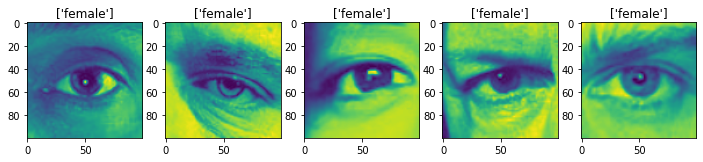

In [357]:
#Lets view some of the pics
import matplotlib.pyplot as plt

X_train__ = X_train.reshape(X_train.shape[0], 100, 100)

fig, axis = plt.subplots(1, 5, figsize=(12, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i])
    digit = y_train[i].argmax()
    class_name = labelencoder.inverse_transform([digit])
    ax.set(title = f"{class_name}");

## Building Model & Hyperparameter tuning
Now we are finally ready, and we can train the model.


In [358]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from numpy.random import seed

%reload_ext tensorboard
seed(1)

epoch_sized = 50
batch_sized = 125
num_classes  = 2

In [359]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(100, 100, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same' ))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))

# add fully connected Dense Layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,metrics=['accuracy'])

In [360]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 12, 12, 256)     

In [361]:
from datetime import  datetime
# Clear any logs from previous runs
!rm -rf ./logs/

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5, min_delta=0, baseline=None, restore_best_weights=True)
lrReduce = ReduceLROnPlateau(monitor='val_loss', patience=3)

In [362]:
#  fit model and train.
history = model.fit(X_train, 
                    y_train, 
                    epochs=epoch_sized,
                    batch_size=batch_sized, 
                    validation_data=(X_test, y_test), 
                    callbacks = [tensorboard_callback, earlyStop]
)

Epoch 1/50
60/60 [==============================] - 5s 71ms/step - loss: 0.6936 - accuracy: 0.5634 - val_loss: 0.6207 - val_accuracy: 0.6513
Epoch 2/50
60/60 [==============================] - 3s 58ms/step - loss: 0.5638 - accuracy: 0.7091 - val_loss: 0.6195 - val_accuracy: 0.6725
Epoch 3/50
60/60 [==============================] - 3s 58ms/step - loss: 0.4405 - accuracy: 0.8000 - val_loss: 0.5573 - val_accuracy: 0.7066
Epoch 4/50
60/60 [==============================] - 3s 58ms/step - loss: 0.4386 - accuracy: 0.8003 - val_loss: 0.3634 - val_accuracy: 0.8444
Epoch 5/50
60/60 [==============================] - 3s 58ms/step - loss: 0.3749 - accuracy: 0.8372 - val_loss: 0.4892 - val_accuracy: 0.7777
Epoch 6/50
60/60 [==============================] - 3s 58ms/step - loss: 0.3948 - accuracy: 0.8265 - val_loss: 0.5413 - val_accuracy: 0.7370
Epoch 7/50
60/60 [==============================] - 3s 57ms/step - loss: 0.4142 - accuracy: 0.8155 - val_loss: 0.3508 - val_accuracy: 0.8552
Epoch 8/50
60

## Validate the model


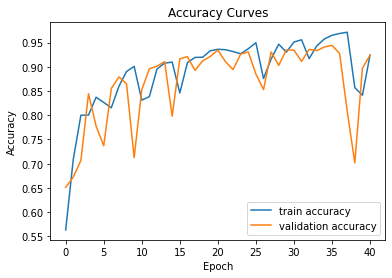

In [363]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend(loc='lower right')

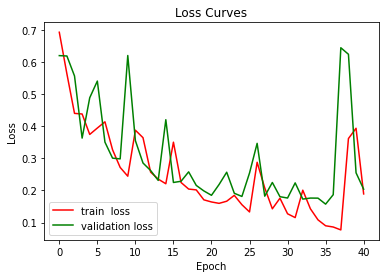

In [364]:
# Plot accuracy per iteration
plt.plot(history.history['loss'], label='train  loss', color='red')
plt.plot(history.history['val_loss'], label='validation loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

In [365]:
## Test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

58/58 - 0s - loss: 0.1574 - accuracy: 0.9441
0.9441431760787964


## Predict The Output For Testing Dataset 😅
We have trained our model, evaluated it and now finally we will predict the output/target for the testing data (i.e. Test.csv).

In [366]:
## Predictions
y_predicted = model.predict(X_test)

In [367]:
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes  validation observations to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = -1) 
y_true = np.argmax(y_test,axis = -1)

# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

# compute the confusion matrix
# print(classification_report(y_true,y_pred_classes,target_names=labelencoder.classes_))

[[Text(0, 0.5, 'female'), Text(0, 1.5, 'male')],
 [Text(0.5, 0, 'female'), Text(1.5, 0, 'male')]]

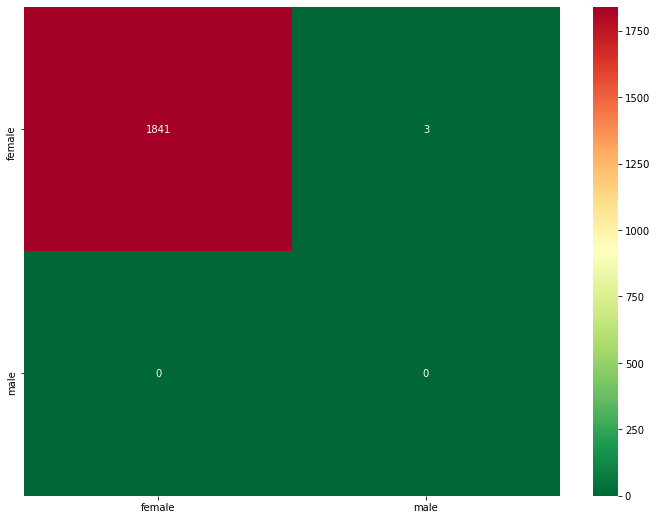

In [368]:
plt.figure(figsize=(12, 9))
cm = sns.heatmap(confusion_mtx, annot=True, cmap=plt.cm.RdYlGn_r, fmt='g' )
cm.set(xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_)

#### Load Test Set
Load the test data on which final submission is to be made.

In [369]:
labels = pd.read_csv("/content/content/eye_gender_data/Testing_set.csv") # loading the labels
file_paths = [[fname, '/content/content/eye_gender_data/test/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_images = pd.merge(images, labels, how = 'inner', on = 'filename')

In [370]:
test_images.head()

,filename,filepaths
0,Image_1.jpg,/content/content/eye_gender_data/test/Image_1.jpg
1,Image_2.jpg,/content/content/eye_gender_data/test/Image_2.jpg
2,Image_3.jpg,/content/content/eye_gender_data/test/Image_3.jpg
3,Image_4.jpg,/content/content/eye_gender_data/test/Image_4.jpg
4,Image_5.jpg,/content/content/eye_gender_data/test/Image_5.jpg


## Data Pre-processing on test_data


In [371]:
print('size of the test data images: ',test_images.shape)

size of the test data images:  (2305, 2)


In [372]:
test_data = []     # initialize an empty numpy array
image_size = 100      # image size taken is 100 here. one can take other size too
X_test_Image = []
for i in range(len(test_images)):  
  test_img_array = cv2.imread(test_images['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
  new_test_img_array = cv2.resize(test_img_array, (image_size, image_size))      # resizing the image array
  test_data.append([new_test_img_array])
  X_test_Image.append([new_test_img_array])

In [373]:
# reshape the Images
X_test_Image_arr = np.array(X_test_Image) / 255.0

# Summarize Loaded Dataset
print('Test data Before reshaping : X_test={}', format(X_test_Image_arr.shape))

X_test_new_arr = X_test_Image_arr.shape
X_test = X_test_Image_arr.reshape(X_test_new_arr[0],X_test_new_arr[2],X_test_new_arr[3], -1)
print('Test data After reshaping : X_test={}', format(X_test.shape))

Test data Before reshaping : X_test={} (2305, 1, 100, 100)
Test data After reshaping : X_test={} (2305, 100, 100, 1)


### Make Prediction on Test **Dataset**

In [374]:
## Predictions
predictions = model.predict(X_test)

prediction values [0.99848586]


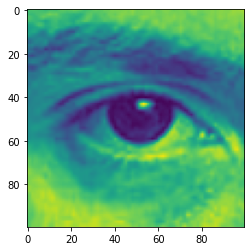

In [375]:
# verif the probability range in test set
print('prediction values', predictions[0])
plt.imshow(np.squeeze(X_test[0],axis=2))

prediction values [0.9295763]


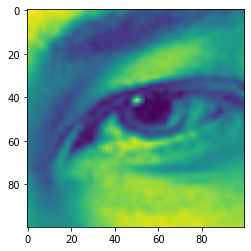

In [376]:
print('prediction values', predictions[229])
plt.imshow(np.squeeze(X_test[229],axis=2))

prediction values [0.00602387]


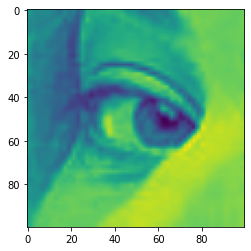

In [377]:
print('prediction values', predictions[230])
plt.imshow(np.squeeze(X_test[230],axis=2))

In [378]:
pred=[]
for i in predictions:
  if i>=0.5:
    pred.append('male')
  else:
    pred.append('female')


In [379]:
pred[229:231]

['male', 'female']

In [380]:
predicts = np.array(predictions)
image_pred_df = pd.DataFrame(predicts, columns=['predict_proba'])

In [381]:
image_pred_df['label']=np.where(image_pred_df['predict_proba'] >= 0.5, 'male', 'female')
predict_final_df = pd.concat([test_images, image_pred_df], axis=1)
predict_final_df = predict_final_df.drop(['filepaths','predict_proba'], axis=1)
predict_final_df.to_csv("submission.csv", index = False) 

In [382]:
# To download the csv file locally
from google.colab import files        
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>